In [1]:
!/usr/bin/python3 -m pip install --upgrade pip
!apt-get update
!apt-get install git -y
!git clone https://github.com/Xtraordinaire9911/neural_network_building.git
!pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install tqdm
!pip install matplotlib
!pip install tensorboard
!pip install tensorboardX

/bin/bash: /usr/bin/python3: No such file or directory
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Fetched 252 kB in 1s (325 kB/s)                                                
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
fatal: destination path 'neural_network_building' already exists and is not an empty directory.
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
!nvidia-smi

Tue Jun 15 00:31:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:68:00.0 Off |                  N/A |
| 30%   44C    P8    27W / 350W |      1MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
# %%timeit
import os
import json
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm
import numpy as np

from model_googlenet import GoogLeNet

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [50]:
def train():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}
    
    print('current root:', os.getcwd())
#     data_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # get data root path
    data_root = os.getcwd()
    print('data_root:', data_root)
    image_path = os.path.join(data_root, "dataset", "flower_data")  # flower data set path
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    # {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
    flower_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in flower_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    batch_size = 32
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=True,
                                                  num_workers=nw)

    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))

    # test_data_iter = iter(validate_loader)
    # test_image, test_label = test_data_iter.next()

    # net = torchvision.models.googlenet(num_classes=5)
    # model_dict = net.state_dict()
    # pretrain_model = torch.load("googlenet.pth")
    # del_list = ["aux1.fc2.weight", "aux1.fc2.bias",
    #             "aux2.fc2.weight", "aux2.fc2.bias",
    #             "fc.weight", "fc.bias"]
    # pretrain_dict = {k: v for k, v in pretrain_model.items() if k not in del_list}
    # model_dict.update(pretrain_dict)
    # net.load_state_dict(model_dict)
    net = GoogLeNet(num_classes=5, if_aux_logits=True, if_init_weights=True)
    net.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0003)

    epochs = 150
    best_acc = 0.0
    l_loss = []
    l_acc = []
    save_path = './GoogLeNet.pth'
    train_steps = len(train_loader)
    for epoch in range(epochs):
        # train
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            logits, aux_logits2, aux_logits1 = net(images.to(device))
            loss0 = loss_function(logits, labels.to(device))
            loss1 = loss_function(aux_logits1, labels.to(device))
            loss2 = loss_function(aux_logits2, labels.to(device))
            loss = loss0 + loss1 * 0.3 + loss2 * 0.3
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            l_loss.append(running_loss)

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm(validate_loader)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))  # eval model only have last output layer
#                 if epoch == 0:
#                     print(type(outputs[0]), outputs[0].size())
#                 predict_y = torch.max(outputs[0], dim=1)
#                 if epoch == 0:
#                     print(type(predict_y[1]), len(predict_y[1]))
                acc += torch.eq(predict_y[1], val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        l_acc.append(val_accurate)
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
            
        if epoch > 10 and np.max(l_acc[-10:]) - np.min(l_acc[-10:]) < 0.02 and val_accurate > 0.75:
            break

    print('Finished Training')
    return l_loss, l_acc

In [51]:
%%time

from tensorboardX import SummaryWriter
writer1 = SummaryWriter('runs02/accuracy')
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs02/accuracy
l_train_loss, l_accuracy = train()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 676), started 3:30:50 ago. (Use '!kill 676' to kill it.)

using cuda:0 device.
current root: /workspace
data_root: /workspace
Using 8 dataloader workers every process
using 3306 images for training, 364 images for validation.


 58%|█████▊    | 7/12 [00:01<00:03,  1.51it/s]

<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> 32
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> 32
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> 32
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> 32
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> 32
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> 32
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> 32
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> 32
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> 32
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> 32


100%|██████████| 12/12 [00:01<00:00,  9.63it/s]


<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> 32
<class 'torch.Tensor'> torch.Size([12, 5])
<class 'torch.Tensor'> 12
[epoch 1] train_loss: 3.694  val_accuracy: 0.415


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 2] train_loss: 1.808  val_accuracy: 0.604


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 3] train_loss: 1.609  val_accuracy: 0.662


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 4] train_loss: 1.541  val_accuracy: 0.621


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 5] train_loss: 1.452  val_accuracy: 0.665


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 6] train_loss: 1.395  val_accuracy: 0.673


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 7] train_loss: 1.367  val_accuracy: 0.698


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 8] train_loss: 1.292  val_accuracy: 0.725


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 9] train_loss: 1.314  val_accuracy: 0.709


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 10] train_loss: 1.249  val_accuracy: 0.657


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 11] train_loss: 1.230  val_accuracy: 0.701


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 12] train_loss: 1.210  val_accuracy: 0.753


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 13] train_loss: 1.171  val_accuracy: 0.731


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 14] train_loss: 1.104  val_accuracy: 0.736


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 15] train_loss: 1.148  val_accuracy: 0.750


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 16] train_loss: 1.156  val_accuracy: 0.780


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 17] train_loss: 1.067  val_accuracy: 0.753


100%|██████████| 12/12 [00:01<00:00,  9.55it/s]


[epoch 18] train_loss: 1.015  val_accuracy: 0.786


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 19] train_loss: 1.041  val_accuracy: 0.783


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 20] train_loss: 1.040  val_accuracy: 0.786


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 21] train_loss: 0.993  val_accuracy: 0.761


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 22] train_loss: 0.965  val_accuracy: 0.799


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 23] train_loss: 0.936  val_accuracy: 0.745


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 24] train_loss: 0.938  val_accuracy: 0.714


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 25] train_loss: 0.864  val_accuracy: 0.794


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 26] train_loss: 0.912  val_accuracy: 0.816


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 27] train_loss: 0.909  val_accuracy: 0.780


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 28] train_loss: 0.853  val_accuracy: 0.766


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 29] train_loss: 0.843  val_accuracy: 0.802


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 30] train_loss: 0.824  val_accuracy: 0.797


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 31] train_loss: 0.856  val_accuracy: 0.794


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 32] train_loss: 0.800  val_accuracy: 0.816


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 33] train_loss: 0.800  val_accuracy: 0.786


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 34] train_loss: 0.787  val_accuracy: 0.780


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 35] train_loss: 0.770  val_accuracy: 0.802


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 36] train_loss: 0.781  val_accuracy: 0.788


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 37] train_loss: 0.795  val_accuracy: 0.808


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 38] train_loss: 0.690  val_accuracy: 0.821


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 39] train_loss: 0.744  val_accuracy: 0.786


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 40] train_loss: 0.707  val_accuracy: 0.802


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 41] train_loss: 0.733  val_accuracy: 0.799


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 42] train_loss: 0.681  val_accuracy: 0.794


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 43] train_loss: 0.698  val_accuracy: 0.791


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 44] train_loss: 0.690  val_accuracy: 0.819


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 45] train_loss: 0.657  val_accuracy: 0.835


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 46] train_loss: 0.665  val_accuracy: 0.827


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 47] train_loss: 0.648  val_accuracy: 0.830


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 48] train_loss: 0.639  val_accuracy: 0.758


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 49] train_loss: 0.637  val_accuracy: 0.791


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 50] train_loss: 0.571  val_accuracy: 0.816


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 51] train_loss: 0.632  val_accuracy: 0.780


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 52] train_loss: 0.612  val_accuracy: 0.819


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 53] train_loss: 0.629  val_accuracy: 0.788


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 54] train_loss: 0.619  val_accuracy: 0.821


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 55] train_loss: 0.588  val_accuracy: 0.788


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 56] train_loss: 0.565  val_accuracy: 0.797


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 57] train_loss: 0.597  val_accuracy: 0.824


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 58] train_loss: 0.558  val_accuracy: 0.816


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 59] train_loss: 0.576  val_accuracy: 0.783


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 60] train_loss: 0.586  val_accuracy: 0.813


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 61] train_loss: 0.535  val_accuracy: 0.824


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 62] train_loss: 0.555  val_accuracy: 0.813


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 63] train_loss: 0.558  val_accuracy: 0.841


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 64] train_loss: 0.498  val_accuracy: 0.824


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 65] train_loss: 0.533  val_accuracy: 0.810


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 66] train_loss: 0.557  val_accuracy: 0.797


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 67] train_loss: 0.517  val_accuracy: 0.791


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 68] train_loss: 0.497  val_accuracy: 0.841


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 69] train_loss: 0.499  val_accuracy: 0.830


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 70] train_loss: 0.553  val_accuracy: 0.819


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 71] train_loss: 0.531  val_accuracy: 0.830


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 72] train_loss: 0.482  val_accuracy: 0.810


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 73] train_loss: 0.477  val_accuracy: 0.805


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 74] train_loss: 0.470  val_accuracy: 0.821


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 75] train_loss: 0.472  val_accuracy: 0.824


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 76] train_loss: 0.494  val_accuracy: 0.838


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 77] train_loss: 0.472  val_accuracy: 0.797


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 78] train_loss: 0.430  val_accuracy: 0.835


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 79] train_loss: 0.488  val_accuracy: 0.835


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 80] train_loss: 0.443  val_accuracy: 0.830


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 81] train_loss: 0.449  val_accuracy: 0.819


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 82] train_loss: 0.458  val_accuracy: 0.786


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 83] train_loss: 0.443  val_accuracy: 0.816


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 84] train_loss: 0.447  val_accuracy: 0.824


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 85] train_loss: 0.495  val_accuracy: 0.843


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 86] train_loss: 0.488  val_accuracy: 0.808


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 87] train_loss: 0.415  val_accuracy: 0.808


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 88] train_loss: 0.398  val_accuracy: 0.816


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 89] train_loss: 0.386  val_accuracy: 0.832


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 90] train_loss: 0.419  val_accuracy: 0.830


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 91] train_loss: 0.437  val_accuracy: 0.838


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 92] train_loss: 0.383  val_accuracy: 0.821


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 93] train_loss: 0.439  val_accuracy: 0.835


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 94] train_loss: 0.408  val_accuracy: 0.838


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 95] train_loss: 0.395  val_accuracy: 0.849


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 96] train_loss: 0.366  val_accuracy: 0.854


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 97] train_loss: 0.343  val_accuracy: 0.838


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 98] train_loss: 0.354  val_accuracy: 0.830


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 99] train_loss: 0.389  val_accuracy: 0.821


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 100] train_loss: 0.360  val_accuracy: 0.813


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 101] train_loss: 0.419  val_accuracy: 0.788


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 102] train_loss: 0.368  val_accuracy: 0.827


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 103] train_loss: 0.380  val_accuracy: 0.827


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 104] train_loss: 0.379  val_accuracy: 0.830


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 105] train_loss: 0.384  val_accuracy: 0.827


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 106] train_loss: 0.340  val_accuracy: 0.827


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 107] train_loss: 0.380  val_accuracy: 0.824


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 108] train_loss: 0.409  val_accuracy: 0.810


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 109] train_loss: 0.379  val_accuracy: 0.830


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 110] train_loss: 0.357  val_accuracy: 0.841


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 111] train_loss: 0.328  val_accuracy: 0.819


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 112] train_loss: 0.364  val_accuracy: 0.841


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 113] train_loss: 0.379  val_accuracy: 0.835


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 114] train_loss: 0.329  val_accuracy: 0.835


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 115] train_loss: 0.362  val_accuracy: 0.832


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 116] train_loss: 0.358  val_accuracy: 0.830


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 117] train_loss: 0.311  val_accuracy: 0.827


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 118] train_loss: 0.318  val_accuracy: 0.813


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 119] train_loss: 0.339  val_accuracy: 0.827


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 120] train_loss: 0.332  val_accuracy: 0.821


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 121] train_loss: 0.310  val_accuracy: 0.821


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 122] train_loss: 0.319  val_accuracy: 0.846


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 123] train_loss: 0.318  val_accuracy: 0.846


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 124] train_loss: 0.322  val_accuracy: 0.813


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 125] train_loss: 0.315  val_accuracy: 0.813


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 126] train_loss: 0.304  val_accuracy: 0.832


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 127] train_loss: 0.282  val_accuracy: 0.832


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 128] train_loss: 0.337  val_accuracy: 0.827


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 129] train_loss: 0.291  val_accuracy: 0.827


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 130] train_loss: 0.321  val_accuracy: 0.835


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 131] train_loss: 0.333  val_accuracy: 0.824


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 132] train_loss: 0.286  val_accuracy: 0.824


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 133] train_loss: 0.310  val_accuracy: 0.868


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 134] train_loss: 0.331  val_accuracy: 0.868


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 135] train_loss: 0.295  val_accuracy: 0.824


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 136] train_loss: 0.288  val_accuracy: 0.860


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 137] train_loss: 0.300  val_accuracy: 0.805


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 138] train_loss: 0.318  val_accuracy: 0.821


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 139] train_loss: 0.276  val_accuracy: 0.816


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 140] train_loss: 0.284  val_accuracy: 0.838


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 141] train_loss: 0.290  val_accuracy: 0.816


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 142] train_loss: 0.320  val_accuracy: 0.830


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 143] train_loss: 0.290  val_accuracy: 0.813


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 144] train_loss: 0.308  val_accuracy: 0.857


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 145] train_loss: 0.300  val_accuracy: 0.838


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 146] train_loss: 0.289  val_accuracy: 0.821


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 147] train_loss: 0.304  val_accuracy: 0.852


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 148] train_loss: 0.286  val_accuracy: 0.827


  0%|          | 0/104 [00:00<?, ?it/s]

[epoch 149] train_loss: 0.281  val_accuracy: 0.835


100%|██████████| 12/12 [00:01<00:00,  9.63it/s]

[epoch 150] train_loss: 0.253  val_accuracy: 0.813
Finished Training
CPU times: user 13min 28s, sys: 6min 2s, total: 19min 30s
Wall time: 20min 16s


In [52]:
!nvidia-smi --query-gpu=memory.free --format=csv

memory.free [MiB]
20564 MiB


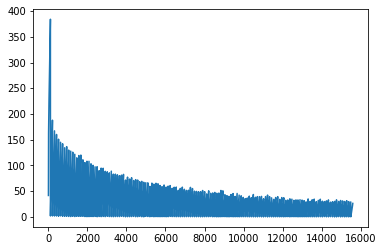

In [53]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(l_train_loss)
plt.savefig("train_loss.jpg")

(0.0, 1.0)

Text(3.5, 0.7802197802197801, '0.83')

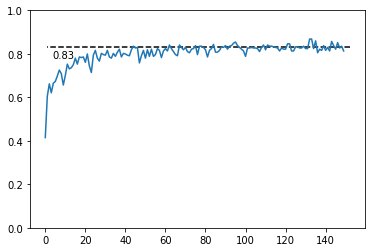

In [59]:
fig = plt.figure()
# plt.xlim(-2, len(l_accuracy)+1)
plt.ylim(0, 1)
plt.hlines(np.mean(l_accuracy[-10:]), len(l_accuracy)+2, l_accuracy[-1], linestyle="dashed", color="black")
plt.text(3.5, np.mean(l_accuracy[-10:])-0.05, '{}'.format(np.round(np.mean(l_accuracy[-10:]), 2), ha='center', va= 'bottom'))
plt.plot(l_accuracy)
plt.savefig("val_acc.jpg")

In [55]:
# len(l_train_loss)
# print(list(map(lambda x: round(x, 2), l_train_loss)))

In [56]:
# len(l_accuracy)
# print(list(map(lambda x: round(x, 3), l_accuracy)))